# Outlier Detection
> 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연

https://scikit-learn.org/stable/modules/outlier_detection.html

**Inliers are labeled 1, while outliers are labeled -1**

In [754]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

from sklearn.datasets import fetch_kddcup99, fetch_covtype, fetch_openml
from sklearn.preprocessing import LabelBinarizer

import tqdm

from pygsp import graphs, filters, plotting, utils

## EbayesThresh

In [894]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [895]:
%%R
library(EbayesThresh)
set.seed(1)
x <- rnorm(1000) + sample(c( runif(25,-7,7), rep(0,975)))
#plot(x,type='l')
#mu <- EbayesThresh::ebayesthresh(x,sdev=2)
#lines(mu,col=2,lty=2,lwd=2)

In [896]:
%R -o x 

In [897]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [898]:
xhat = np.array(ebayesthresh(FloatVector(x)))

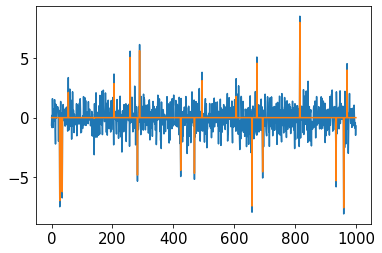

In [899]:
plt.plot(x)
plt.plot(xhat)

In [900]:
outlier_true_index = np.where(xhat!=0)

In [901]:
outlier_true_value = xhat[xhat!=0]

## sklearn.neighbors.LocalOutlierFactor

### 1. sin

In [998]:
_x = np.linspace(0,2,1000)
_y1 =  3*np.sin(_x) + 1*np.sin(_x**2) + 5*np.sin(5*_x) 
_y = _y1 + x # x is epsilon

In [999]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [1000]:
_df1=pd.DataFrame({'x':_x, 'y':_y})

In [1001]:
X = np.array(_df)

In [1002]:
clf = LocalOutlierFactor(n_neighbors=2)

In [1003]:
clf.fit_predict(X)

array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
       -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1,
        1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1, -1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

outlier

In [1004]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [1005]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [1006]:
len(df[outlier_first_index])

121

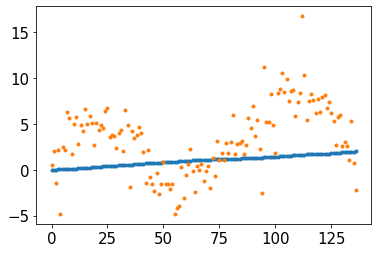

In [1007]:
plt.plot(df[outlier_first],'.')

In [1008]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [1009]:
w=np.zeros((1000,1000))

In [1010]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1011]:
_simul = SIMUL(_df)

In [1012]:
_simul.fit()

In [1013]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [1014]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [1015]:
len(_simul.df.query('Residual**2>2'))

179

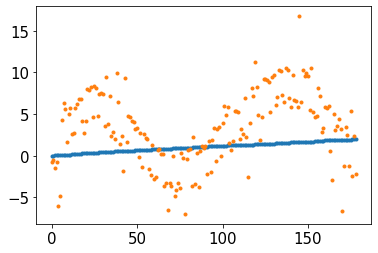

In [1016]:
plt.plot(df[_simul.df.query('Residual**2>2').reset_index()['index'],],'.')

In [1017]:
len(outlier_true_value)

49

In [1018]:
len(outlier_first_value)

121

In [1019]:
len(_simul.df.query('Residual**2>2'))

179

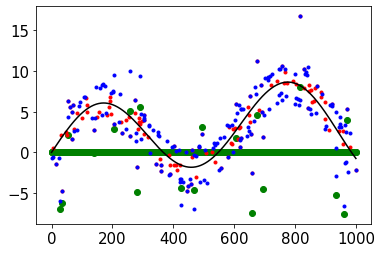

In [1020]:
plt.plot(xhat,'go')
plt.plot(_df.loc[outlier_first_index].reset_index()['index'],_df.loc[outlier_first_index].reset_index()['y'],'r.')
plt.plot(outlier_simul_first_index,outlier_simul_first_value,'b.')
plt.plot(_y1,'k-')

In [1021]:
len(np.intersect1d(outlier_true_index,outlier_first_index))

11

In [1022]:
len(np.intersect1d(outlier_true_index,outlier_first_index))/len(np.array(outlier_true_index).tolist()[0])

0.5789473684210527

In [1023]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))

19

In [1024]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))/len(np.array(outlier_true_index).tolist()[0])

1.0

### 2. two dimensional manifold

In [1025]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=2+np.sin(np.linspace(0,6*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,3*pi,n))
f = f1 + x

In [1026]:
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})

In [1027]:
X = np.array(_df)

In [1028]:
clf = LocalOutlierFactor(n_neighbors=2)

In [1029]:
clf.fit_predict(X)

array([ 1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
       -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1, -1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1, -1

outlier

In [1030]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [1031]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [1032]:
len(df[outlier_first_index])

129

In [1033]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=60): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

In [1034]:
_simul = SIMUL(_df)

In [1035]:
_simul.get_distance()

100%|██████████| 1000/1000 [00:02<00:00, 483.69it/s]


In [1036]:
_simul.get_weightmatrix(theta=(_simul.D[_simul.D>0].mean()),kappa=2500) 

In [1037]:
_simul.fit()

In [1038]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [1039]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [1040]:
len(_simul.df.query('Residual**2>2'))

205

In [1041]:
len(outlier_true_value)

49

In [1042]:
len(outlier_first_value)

129

In [1043]:
len(_simul.df.query('Residual**2>2'))

205

In [1044]:
len(np.intersect1d(outlier_true_index,outlier_first_index))

14

In [1045]:
len(np.intersect1d(outlier_true_index,outlier_first_index))/len(np.array(outlier_true_index).tolist()[0])

0.7368421052631579

In [1046]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))

19

In [1047]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))/len(np.array(outlier_true_index).tolist()[0])

1.0

### 3. Bunny

In [1048]:
G = graphs.Bunny()
n = G.N

In [1049]:
g = filters.Heat(G, tau=75) 

In [1050]:
normal = np.random.randn(n)*0.3
unif = np.concatenate([np.random.rand(63)*3, np.zeros(n-63)]); np.random.shuffle(unif)
noise = normal + unif 

In [1051]:
outlier_true_index = np.where(noise>1)

In [1052]:
outlier_true_value = noise[noise>1]

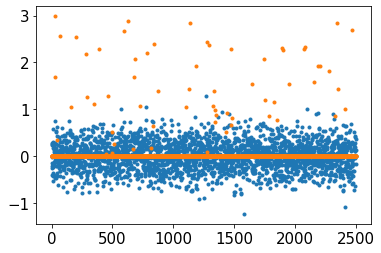

In [1053]:
plt.plot(normal,'.')
plt.plot(unif,'.')
#plt.plot(noise,'--')

In [1054]:
f = np.zeros(n)
f[1000] = 3234
f = g.filter(f, method='chebyshev') 

2022-10-28 13:31:56,351:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


In [1055]:
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = G.coords[:,2]

In [1056]:
_df = pd.DataFrame({'x' : _x, 'y' : _y, 'z' : _z, 'f' : f, 'noise' : noise})

In [1057]:
X = np.array(_df)

In [1058]:
clf = LocalOutlierFactor(n_neighbors=2)

In [1059]:
clf.fit_predict(X[:,:4])

array([1, 1, 1, ..., 1, 1, 1])

outlier

In [1060]:
outlier_first_index = np.where(clf.fit_predict(X[:,:4])==-1)

In [1061]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X[:,:4])==-1]

In [1062]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.z = df.z.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.noise = df.noise.to_numpy()
        self.fnoise = self.f + self.noise
        self.W = W
        self.n = len(self.f)
        self.theta= None
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=6): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.fnoise # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fnoise = self.fnoise)
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f + self.df.noise - self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

In [1063]:
_simul = SIMUL(_df)

In [1064]:
_simul.fit()

In [1065]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>2').reset_index()['index'])

In [1066]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>2').reset_index()['y'])

In [1067]:
len(outlier_true_value)

49

In [1068]:
len(outlier_first_value)

33

In [1069]:
len(_simul.df.query('Residual**2>2'))

33

In [1070]:
len(np.intersect1d(outlier_true_index,outlier_first_index))

1

In [1071]:
len(np.intersect1d(outlier_true_index,outlier_first_index))/len(np.array(outlier_true_index).tolist()[0])

0.02040816326530612

In [1072]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))

32

In [1073]:
len(np.intersect1d(outlier_true_index,outlier_simul_first_index))/len(np.array(outlier_true_index).tolist()[0])

0.6530612244897959

---

## Robust covariance estimation and Mahalanobis distances relevance

In [1075]:
X = np.array(_df1)

In [1076]:
gen_cov = np.eye(2)
gen_cov[0, 0] = 2.0
outliers_cov = np.eye(2)
outliers_cov[np.arange(1, 2), np.arange(1, 2)] = 7.0
#X[-19:] = np.dot(np.random.randn(19, 2), outliers_cov)

In [1077]:
outlier_true_index = np.where(xhat!=0)

In [1079]:
X[outlier_true_index] = np.dot(np.random.randn(19, 2), outliers_cov)

In [1080]:
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance, MinCovDet

# fit a MCD robust estimator to data
robust_cov = MinCovDet().fit(X)
# fit a MLE estimator to data
emp_cov = EmpiricalCovariance().fit(X)
print(
    "Estimated covariance matrix:\nMCD (Robust):\n{}\nMLE:\n{}".format(
        robust_cov.covariance_, emp_cov.covariance_
    ))

Estimated covariance matrix:
MCD (Robust):
[[ 0.1536288  -0.51890293]
 [-0.51890293  8.3341086 ]]
MLE:
[[ 0.38435471  0.42938002]
 [ 0.42938002 12.52298133]]


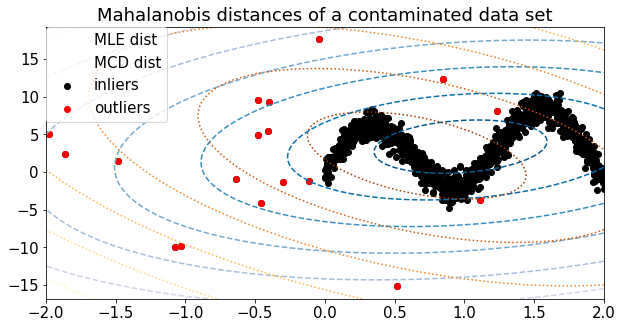

In [1081]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot data set
inlier_plot = ax.scatter(X[:, 0], X[:, 1], color="black", label="inliers")
outlier_plot = ax.scatter(
    X[:, 0][outlier_true_index], X[:, 1][outlier_true_index], color="red", label="outliers"
)
ax.set_xlim(-2.0, 2.0)
ax.set_title("Mahalanobis distances of a contaminated data set")
xx, yy = np.meshgrid(
    np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
    np.linspace(plt.ylim()[0], plt.ylim()[1], 100),
)
zz = np.c_[xx.ravel(), yy.ravel()]
# Calculate the MLE based Mahalanobis distances of the meshgrid
mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = plt.contour(
    xx, yy, np.sqrt(mahal_emp_cov), cmap=plt.cm.PuBu_r, linestyles="dashed"
)
# Calculate the MCD based Mahalanobis distances
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = ax.contour(
    xx, yy, np.sqrt(mahal_robust_cov), cmap=plt.cm.YlOrBr_r, linestyles="dotted"
)

# Add legend
ax.legend(
    [
        emp_cov_contour.collections[1],
        robust_contour.collections[1],
        inlier_plot,
        outlier_plot,
    ],
    ["MLE dist", "MCD dist", "inliers", "outliers"],
    loc="upper left",
    borderaxespad=0,
)

plt.show()
